In [3]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [4]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 10
Número de ecgs que eram pra ser processados: 10
Número total de traçados processados: 10


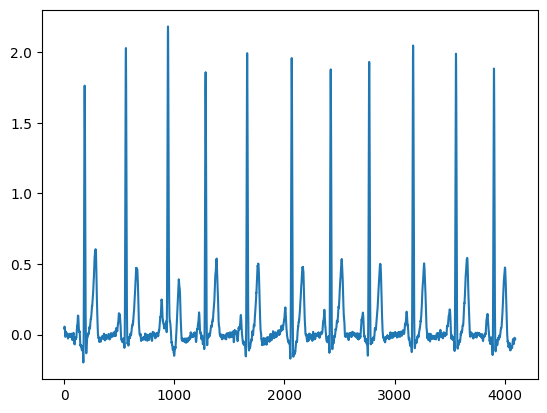

In [ ]:
X = carregar_ecgs(normal=10,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=0,filtrado=True)

plt.plot(X[0][0])

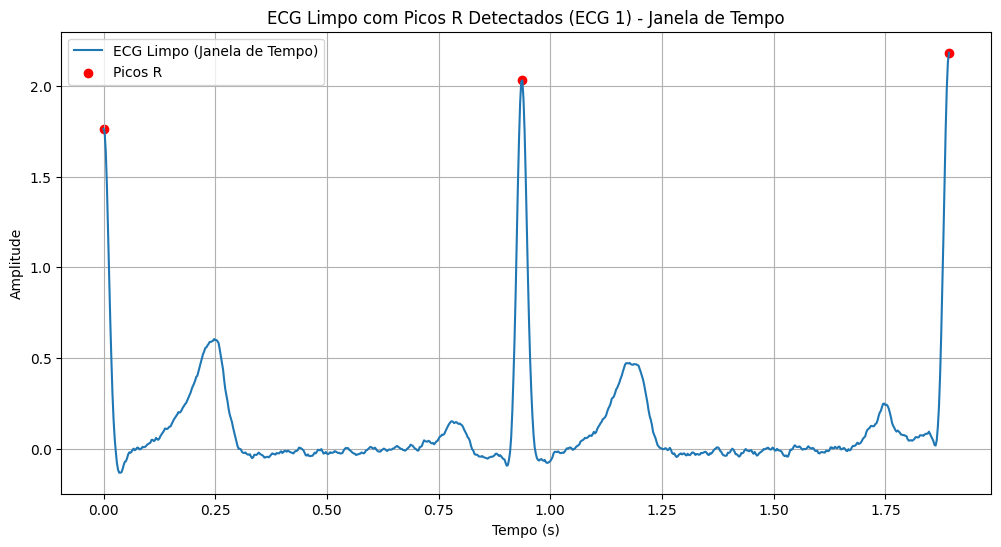

In [6]:
# Função para processar ECGs e armazenar R peaks
def processar_ecgs_multileads(ecgs):
    """
    Processa um vetor de ECGs com múltiplas derivações. Para cada ECG, limpa o sinal na primeira derivação,
    detecta os picos R e faz o corte sincronizado em todas as derivações.

    Parâmetros:
    ecgs: array 3D (n_ecgs x n_leads x n_samples) - Matriz contendo vários ECGs de múltiplas derivações

    Retorno:
    novo_ecgs: lista de arrays - Lista de ECGs processados
    r_peaks_list: lista de arrays - Lista contendo os índices dos R peaks relativos para cada ECG
    """
    n_ecgs, n_leads, n_samples = ecgs.shape
    novo_ecgs = []        # Lista para armazenar os novos ECGs processados
    r_peaks_list = []     # Lista para armazenar os R peaks de cada ECG
    picos_reais = []
    for i in range(n_ecgs):
        # Para cada ECG, obter as derivações
        ecg = ecgs[i]

        # Limpar o sinal da primeira derivação
        first_lead = ecg[0]
        sampling_rate = 400
        

        # Detectar picos R no sinal limpo
        peaks = nk.ecg_findpeaks(first_lead, sampling_rate=sampling_rate)

        # Extrair os índices dos picos R da primeira derivação
        r_peaks = peaks['ECG_R_Peaks']

        # Verificar se há picos suficientes
        if len(r_peaks) < 3:
            print(f"ECG {i + 1}: Não foram detectados picos R suficientes para processamento.")
            novo_ecgs.append(ecg)  # Adiciona o ECG original sem cortes
            r_peaks_list.append([])  # Adiciona uma lista vazia para R peaks
            continue

        # Calcular as distâncias entre os picos consecutivos
        distancias = np.diff(r_peaks)

        # Calcular a mediana das distâncias
        mediana = np.median(distancias)

        # Encontrar o índice do pico cuja distância está mais próxima da mediana
        indice_prox_mediana = np.argmin(np.abs(distancias - mediana))

        # Selecionar os três picos consecutivos
        if indice_prox_mediana + 3 > len(r_peaks):
            # Se não houver picos suficientes, seleciona os últimos três
            novo_ecg_peaks = r_peaks[-3:]
        else:
            novo_ecg_peaks = r_peaks[indice_prox_mediana:indice_prox_mediana + 3]

        # Garantir que temos pelo menos dois pontos para cortar
        if len(novo_ecg_peaks) < 2:
            print(f"ECG {i + 1}: Não foi possível selecionar picos R suficientes para corte.")
            novo_ecgs.append(ecg)  # Adiciona o ECG original sem cortes
            r_peaks_list.append([])  # Adiciona uma lista vazia para R peaks
            continue

        # Definir início e fim da janela
        start = novo_ecg_peaks[0]
        # Ajuste do fim para incluir o último pico sem exceder o número de amostras
        end = novo_ecg_peaks[-1] + 1 if (novo_ecg_peaks[-1] + 1) <= n_samples else novo_ecg_peaks[-1]

        # Criar um novo vetor de ECG para todas as derivações a partir desses picos
        novo_ecg_segmentado = ecg[:, start:end]

        # Substituir ou remover valores NaN
        novo_ecg_segmentado = np.nan_to_num(novo_ecg_segmentado, nan=0.0)

        # Ajustar os R peaks para a janela segmentada (índices relativos)
        r_peaks_window = novo_ecg_peaks - start
        # Garantir que os índices estão dentro dos limites
        r_peaks_window = r_peaks_window[r_peaks_window < (end - start)]

        # Adicionar o novo ECG processado à lista (com diferentes tamanhos)
        novo_ecgs.append(novo_ecg_segmentado)

        # Adicionar os R peaks relativos à lista
        r_peaks_list.append(r_peaks_window)
        
        picos_reais.append(novo_ecg_peaks)
        # Plotar o primeiro ECG como exemplo
        if i == 0:  # Plota apenas o primeiro ECG processado
            time_window = np.arange(end - start) / sampling_rate  # Tempo em segundos
            plt.figure(figsize=(12, 6))
            plt.plot(time_window, first_lead[start:end], label="ECG Limpo (Janela de Tempo)")
            # Ajustar os índices dos picos R para a janela
            plt.scatter(time_window[r_peaks_window], first_lead[novo_ecg_peaks], color='red', label="Picos R")
            plt.title(f"ECG Limpo com Picos R Detectados (ECG {i + 1}) - Janela de Tempo")
            plt.xlabel("Tempo (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid()
            plt.show()

    return novo_ecgs, r_peaks_list, picos_reais

# Processar os ECGs
novo_ecg, r_peaks_list, picos = processar_ecgs_multileads(X)

In [41]:
import cupy as cp
import torch

def criar_grafo_visibilidade_pt(vetor, pt_path='grafo_visibilidade.pt'):
    """
    Cria o grafo de visibilidade com algoritmo O(n²), gera tensores 'src' e 'dst' no PyTorch e salva no arquivo .pt.
    
    Args:
        vetor (array-like): Vetor 1D com os valores da série temporal. Pode ser np.ndarray ou já no GPU (cp.array).
        pt_path (str): Caminho do arquivo .pt onde serão salvos os tensores.

    Retorna:
        None. (Salva 'src' e 'dst' no arquivo .pt)
    """
    # Certifica que está em GPU com cupy
    if not isinstance(vetor, cp.ndarray):
        vetor = cp.array(vetor)

    n = len(vetor)
    src_list = []
    dst_list = []

    # Visibilidade para a direita
    for i in range(n):
        valor_i = vetor[i]  # valor do ponto i
        indices = cp.arange(i+1, n)
        if len(indices) == 0:
            continue

        # Calcula as inclinações (slopes) vetorizadamente
        slopes = (vetor[indices] - valor_i) / (indices - i)

        # Percorre slopes para encontrar nós visíveis
        # Ao invés de percorrer um a um, faremos uma varredura:
        # Estratégia: mantenha track do max_slope encontrado até agora.
        # Convertemos slopes para CPU temporariamente para fazer a varredura rápida em Python.
        # Opcionalmente, pode-se fazer um kernel personalizado em GPU, mas isso já é bem rápido.
        slopes_cpu = cp.asnumpy(slopes)
        
        max_slope = -float('inf')
        for offset, s in enumerate(slopes_cpu):
            if s > max_slope:
                max_slope = s
                j = i + 1 + offset
                src_list.append(i)
                dst_list.append(j)
                # Não paramos, pois um ponto mais distante pode ter slope maior ainda.
    """
    # Visibilidade para a esquerda
    # Mesmo processo, mas para a esquerda
    for i in range(n):
        valor_i = vetor[i]
        indices = cp.arange(i-1, -1, -1)
        if len(indices) == 0:
            continue
        slopes = (vetor[indices] - valor_i) / (indices - i)
        slopes_cpu = cp.asnumpy(slopes)

        max_slope = -float('inf')
        for offset, s in enumerate(slopes_cpu):
            if s > max_slope:
                max_slope = s
                j = i - 1 - offset
                src_list.append(j)
                dst_list.append(i)
    """
    # Converte listas para tensores PyTorch e salva
    src_t = torch.tensor(src_list, dtype=torch.long)
    dst_t = torch.tensor(dst_list, dtype=torch.long)

    torch.save({'src': src_t, 'dst': dst_t}, pt_path)
    print(f"Grafo de visibilidade salvo em {pt_path} com {len(src_list)} arestas.")


# Exemplo de uso:
if __name__ == "__main__":
    # Substitua "novo_ecg[0][0]" pelo seu vetor real
    vetor = X[0][0]  # Por exemplo, um numpy array com a série temporal
    criar_grafo_visibilidade_pt(vetor, pt_path='grafo_visibilidade.pt')


Grafo de visibilidade salvo em grafo_visibilidade.pt com 96408 arestas.


/tmp/ipykernel_781235/1987466892.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_salvos = torch.load(pt_path)


Tensores 'src' e 'dst' carregados com sucesso.
Grafo criado com 4096 nós e 96408 arestas.


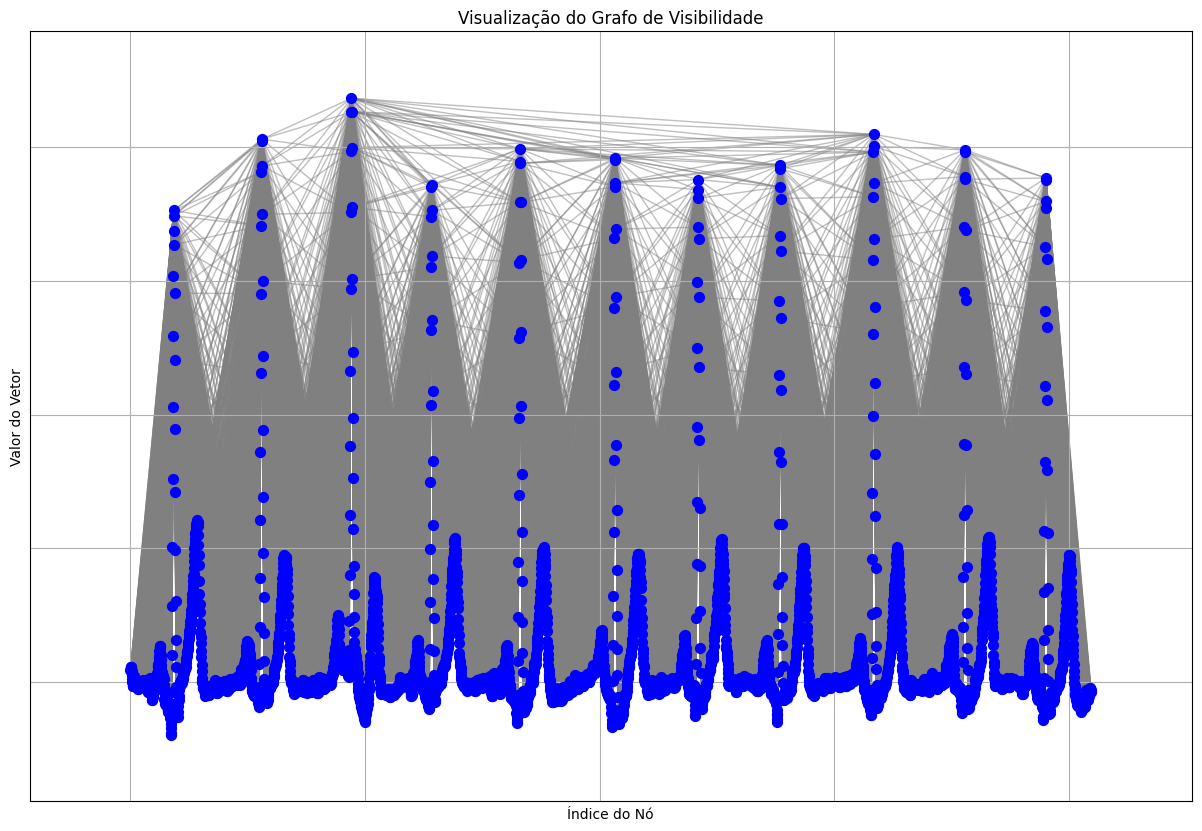

In [40]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualizar_grafo_com_matplotlib(pt_path, vetor):
    """
    Carrega os tensores salvos em um arquivo .pt e visualiza o grafo usando Matplotlib.

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os tensores 'src' e 'dst'.
        vetor (numpy.ndarray): Vetor de características usado para definir as posições dos nós.
    """
    # Carrega os tensores salvos
    try:
        dados_salvos = torch.load(pt_path)
        src = dados_salvos['src'].cpu().numpy()
        dst = dados_salvos['dst'].cpu().numpy()
        print("Tensores 'src' e 'dst' carregados com sucesso.")
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return
    
    # Verifica se o vetor tem o mesmo número de nós que esperado
    num_nodes = len(vetor)
    max_node = max(np.max(src), np.max(dst))
    if max_node >= num_nodes:
        print("Atenção: O vetor fornecido não cobre todos os nós do grafo.")
        num_nodes = max_node + 1  # Atualiza o número de nós
    
    # Criar o grafo com NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(zip(src, dst))
    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
    
    # Definir posições dos nós
    # Exemplo: x = índice do nó, y = valor do vetor
    pos = {i: (i, vetor[i]) for i in range(num_nodes)}
    
    # Plotar o grafo
    plt.figure(figsize=(15, 10))
    # Desenhar arestas
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    # Desenhar nós
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    # Opcional: adicionar rótulos aos nós
    # nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Visualização do Grafo de Visibilidade")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Valor do Vetor")
    plt.grid(True)
    plt.show()

# Exemplo de uso:
if __name__ == "__main__":
    # Caminho para o arquivo .pt salvo anteriormente
    pt_path = 'grafo_visibilidade.pt'
    
    # Carregar o vetor original usado para criar o grafo
    # Substitua esta linha com a forma adequada de obter seu vetor real
    # Por exemplo, se você salvou o vetor em um arquivo, carregue-o aqui
    # Aqui, vou usar um vetor de exemplo com 100 pontos
    vetor = X[0][0] # Substitua com seus dados reais
    
    # Chamar a função de visualização
    visualizar_grafo_com_matplotlib(pt_path, vetor)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.optim as optim

# 1. Carregar os tensores src e dst
pt_path = 'grafo_visibilidade.pt'
dados_salvos = torch.load(pt_path)
src = dados_salvos['src']
dst = dados_salvos['dst']

# 2. Definir as características dos nós
num_nodes = max(src.max().item(), dst.max().item()) + 1
F = 16  # Dimensão das características
x = torch.ones((num_nodes, F))  # Exemplo: vetores de uns

# 3. Criar o objeto Data
edge_index = torch.stack([src, dst], dim=0)
data = Data(x=x, edge_index=edge_index)

# 4. Adicionar rótulos e máscaras (se aplicável)
C = 2  # Número de classes
y = torch.randint(0, C, (num_nodes,))  # Rótulos aleatórios
data.y = y

# Máscaras
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_indices = torch.arange(0, int(0.6 * num_nodes))
val_indices = torch.arange(int(0.6 * num_nodes), int(0.8 * num_nodes))
test_indices = torch.arange(int(0.8 * num_nodes), num_nodes)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# 5. Mover dados para GPU (opcional)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# 6. Definir a GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = GCN(num_features=F, hidden_dim=16, num_classes=C).to(device)

# 7. Definir otimizador e função de perda
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

# 8. Funções de treino e avaliação
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc

# 9. Treinar a GCN
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        train_acc = evaluate(data.train_mask)
        val_acc = evaluate(data.val_mask)
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

# 10. Avaliar no conjunto de teste
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")
